# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.
Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.
## Описание данных
*Признаки:*
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

*Целевой признак:*
- Price — цена (евро)

## Постановка задачи
### [Шаг 1. Знакомство с данными, их изучение и предобработка](#section1)
Загрузите и изучите данные.
### [Шаг 2. Работа с моделями](#section2)
Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
### [Шаг 3. Оценка качества моделей:](#section3)
Проанализируйте скорость работы и качество моделей.
### [Шаг 4. Общий вывод](#section4)


Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

# Решение задачи
## Шаг 1. Знакомство с данными, их изучение и предобработка <a class="anchor" id="section1"></a>

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
# !pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

RANDOM_VAL = np.random.RandomState(42)
RAND = 42

Загрузим данные.

In [3]:
try:
    autos_data = pd.read_csv('autos.csv')
except:
    autos_data = pd.read_csv('/datasets/autos.csv')

Приведем названия столбцов к красивому виду.

In [4]:
autos_data.columns = autos_data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [5]:
# Функция оценки пропусков в таблице
def pass_value_barh(data):
    try:
        (
            (data.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: 'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(20, 10), legend=False, fontsize=10)
            .set_title('Пропущенные значения, %' + "\n", fontsize=22)
        )
        print('Всего значений в таблице {0}, из них пропущено от {1} до {2} значений, доля пропущенных '
              'равна от {3:.2%} до {4:.2%} в {5} столбцах.'.format(len(data),
                                                                   min(i for i in data.isna().sum() if i > 0),
                                                                   max(data.isna().sum()),
                                                                   min(i for i in data.isna().sum() if i > 0) / len(
                                                                       data),
                                                                   max(data.isna().sum()) / len(data),
                                                                   (data.isna().sum(axis=0) > 0).sum()
                                                                   ))
    except:
        print('пропусков не осталось :) ')

In [6]:
# Функция изучения данных в таблице
def research_info(data):
    rows_count, columns_count = data.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {}'.format(data.duplicated().sum()))
    display(data.sample(n=5))
    pass_value_barh(data)

Количество стобцов: 16
Количество строк: 354369
Дубликатов: 4


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
64196,2016-03-16 13:46:22,1700,NaN,1995,manual,133,80,150000,0,petrol,audi,NaN,2016-03-16 00:00:00,0,94034,2016-04-06 10:18:03
271867,2016-03-12 17:46:44,600,NaN,2017,manual,45,corsa,125000,10,petrol,opel,no,2016-03-12 00:00:00,0,1762,2016-03-17 20:45:52
260725,2016-03-17 21:54:30,0,sedan,2000,NaN,0,s_type,150000,12,petrol,jaguar,NaN,2016-03-17 00:00:00,0,69207,2016-03-26 04:17:38
154270,2016-03-19 09:56:52,280,NaN,2000,manual,0,other,125000,0,petrol,mazda,NaN,2016-03-19 00:00:00,0,67063,2016-03-25 10:45:41
49535,2016-03-26 21:25:35,2500,bus,2005,manual,75,transit,150000,7,gasoline,ford,no,2016-03-26 00:00:00,0,35516,2016-03-30 09:18:28


Всего значений в таблице 354369, из них пропущено от 19705 до 71154 значений, доля пропущенных равна от 5.56% до 20.08% в 5 столбцах.


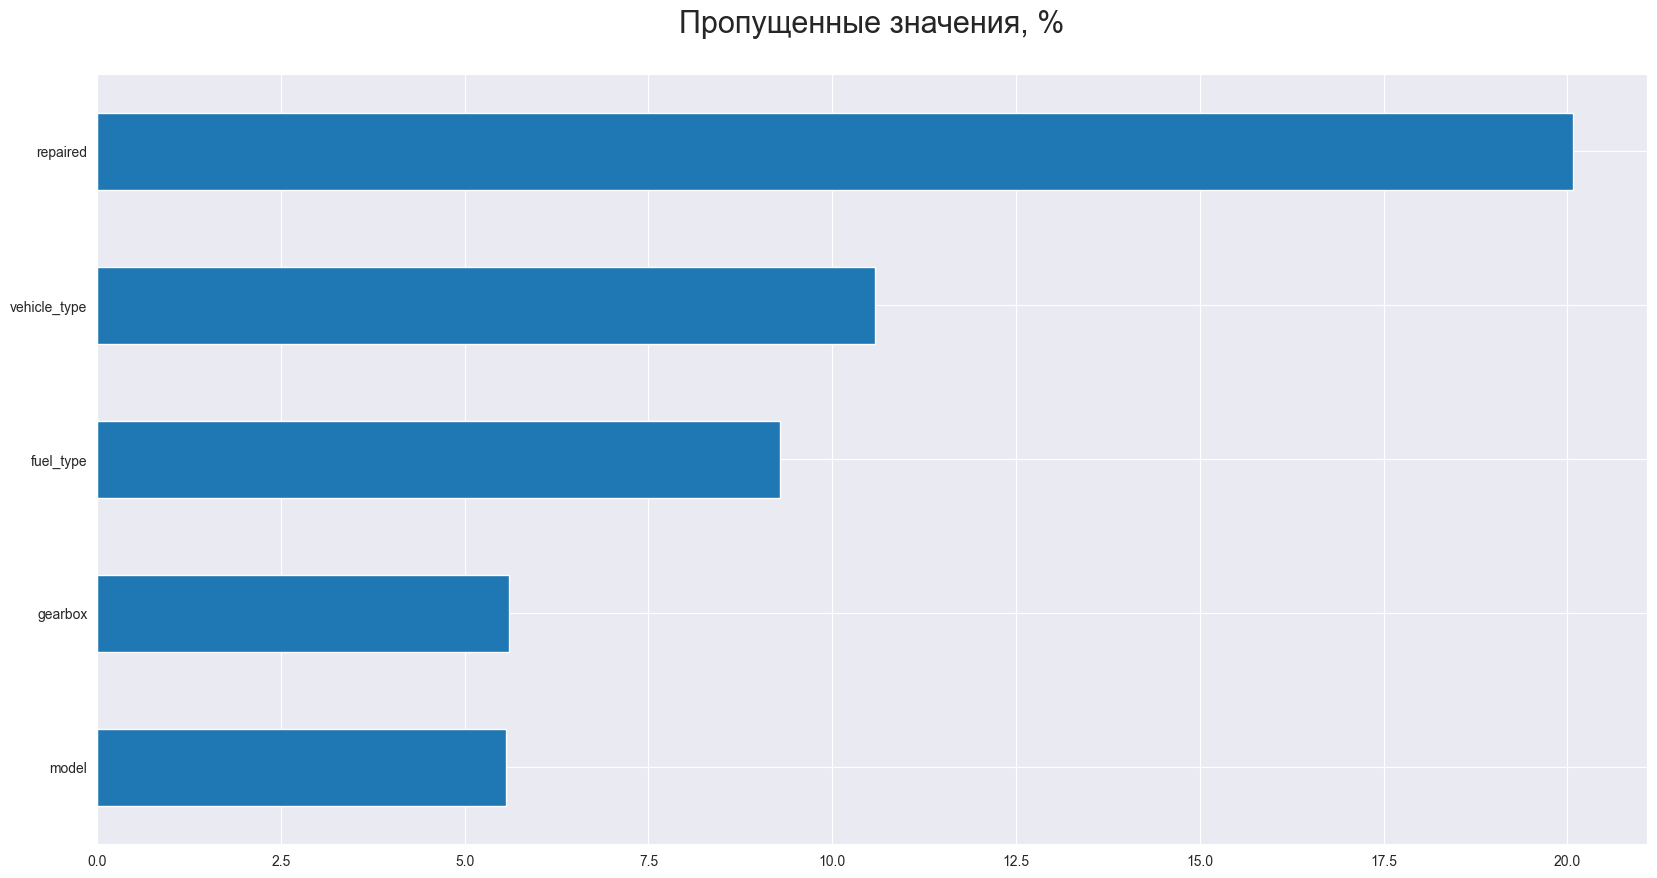

In [7]:
research_info(autos_data)
len_before = autos_data.shape[0]

Посмотрим на распределение данных

In [8]:
autos_data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


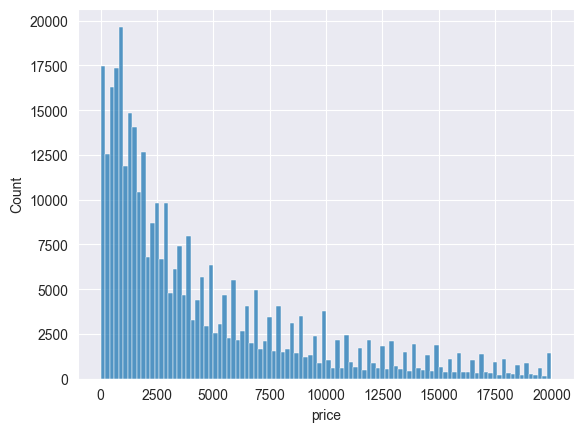

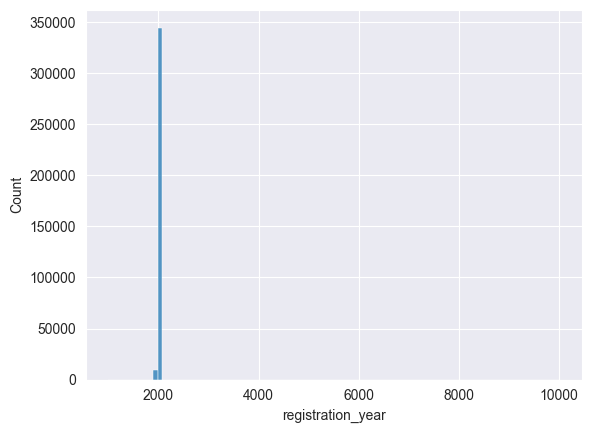

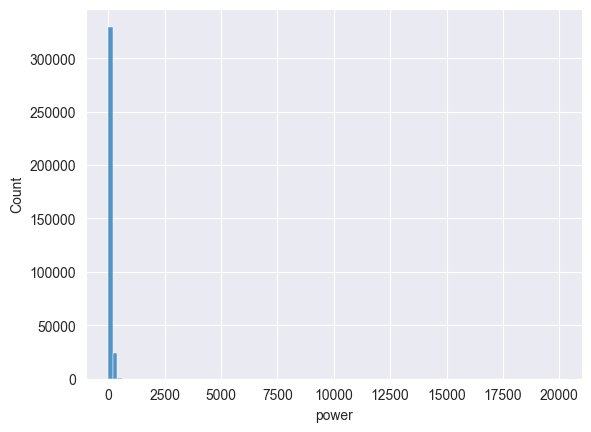

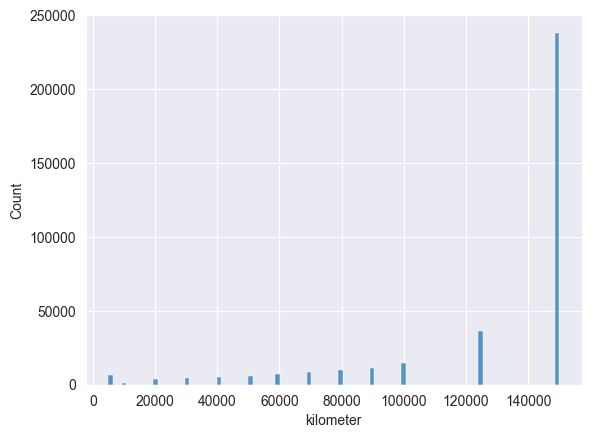

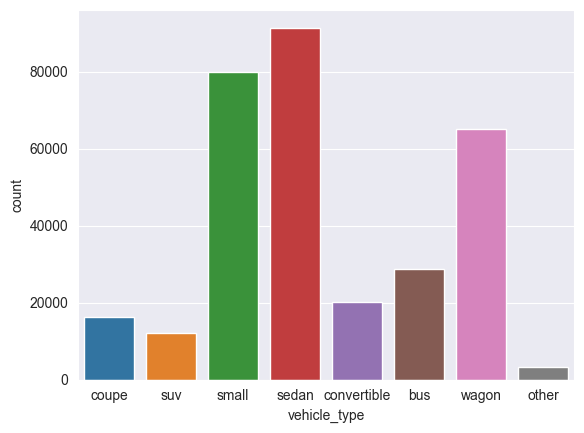

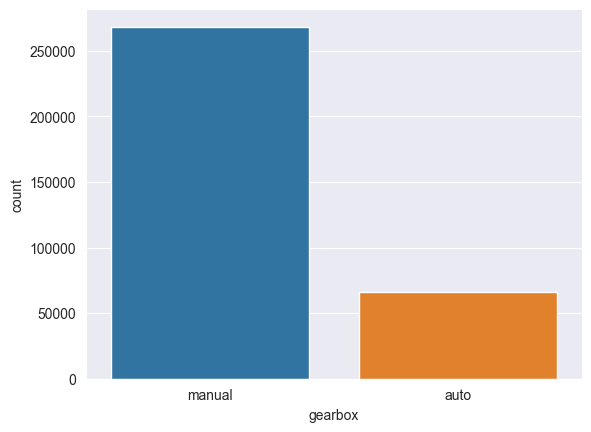

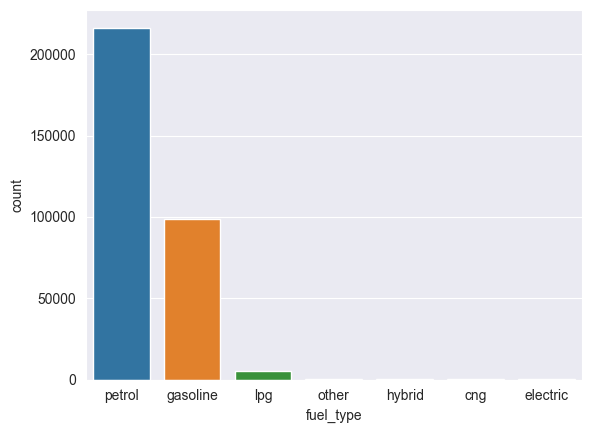

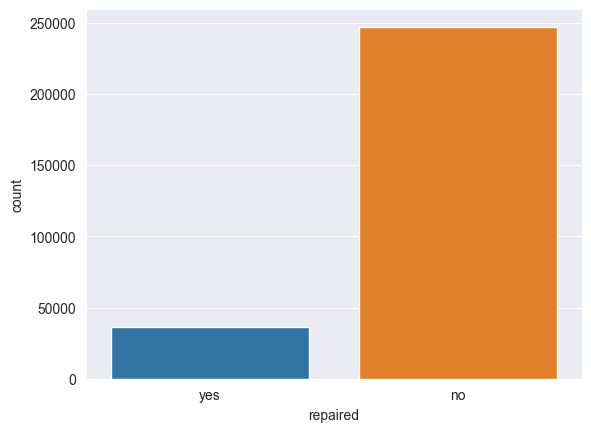

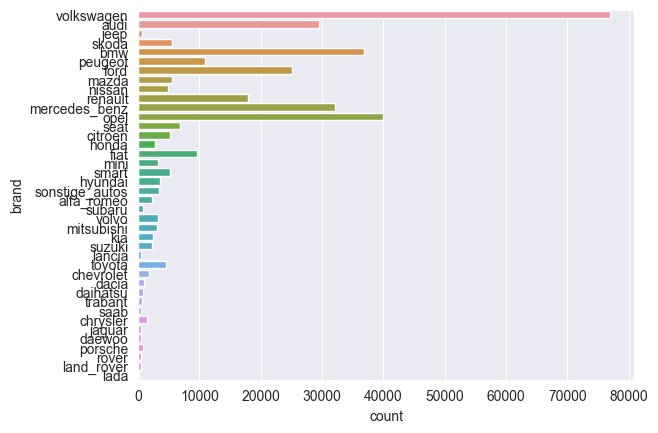

In [9]:
numeric_columns = ['price', 'registration_year', 'power', 'kilometer']
cat_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

for column in numeric_columns:
    sns.histplot(autos_data[column], bins=100)
    plt.show()

for column in cat_columns:
    sns.countplot(autos_data[column])
    plt.show()

for column in ['brand']:
    sns.countplot(y=column, data=autos_data, orient='h')
    plt.show()

cat_columns.append('brand')
cat_columns.append('model')

In [10]:
print('Количество пропусков в столбце `model` {}, доля пропусков {:.2%}'.format(autos_data['model'].isna().sum(),
                                                                                autos_data['model'].isna().sum() / len(
                                                                                    autos_data)))

Количество пропусков в столбце `model` 19705, доля пропусков 5.56%


Столбцы, требующие обработки:
- `vehicle_type` - для всех NaN восстановим по ближайшим соседям заполненных типов кузовов для схожих по модели и бренду;
- `gearbox` - для всех NaN установим значение `manual`, т.к. доля автомобилей с ручной коробкой все ещё существенно больше, чем с автоматом;
- `power` - удалим выбросы на основе реальных значений в машинах. Иметь 15000 л.с. для машины на данный момент нереально;
- `fuel_type` - для всех NaN установим значение `petrol`, как самый распространенный тип топлива, а также заменим `gasoline` на `petrol`, так как и то и то является бензином;
- `repaired` - для всех NaN установим значение `no`;
- `registration_year` - удалим выбросы, учитывая, что массовый выпуск автомобилей начался после 1908;
- `model` - заменим пропуски в столбце на заглушку 'unknown'.

In [11]:
autos_data['vehicle_type'] = autos_data.groupby(['brand', 'model'])['vehicle_type'].bfill().ffill()

In [12]:
autos_data.fillna({'gearbox': 'manual', 'fuel_type': 'petrol', 'repaired': 'no'}, inplace=True)

In [13]:
autos_data['fuel_type'] = autos_data['fuel_type'].replace(['gasoline'], 'petrol')

In [14]:
# autos_data.dropna(subset=['model'], inplace=True)
autos_data.fillna({'model': 'unknown'}, inplace=True)

In [15]:
print('Дата последнего обращения к сайту:', autos_data['date_crawled'].max())

Дата последнего обращения к сайту: 2016-04-07 14:36:58


In [16]:
print(sorted(set(autos_data['registration_year'])))

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


Дата формирования датасета - март и апрель 2016 года, значит модели, зарегистрированные после 2016 года, не могут быть действительны, также конвейерное производство автомобилей, а значит и доступность для покупки-продажи, началось с 1908 года. Исходя из этих факторов, удалим строки с датой регистрации до 1908 и после 2016.

In [17]:
autos_data = autos_data.query('registration_year >= 1908 & registration_year < 2017')

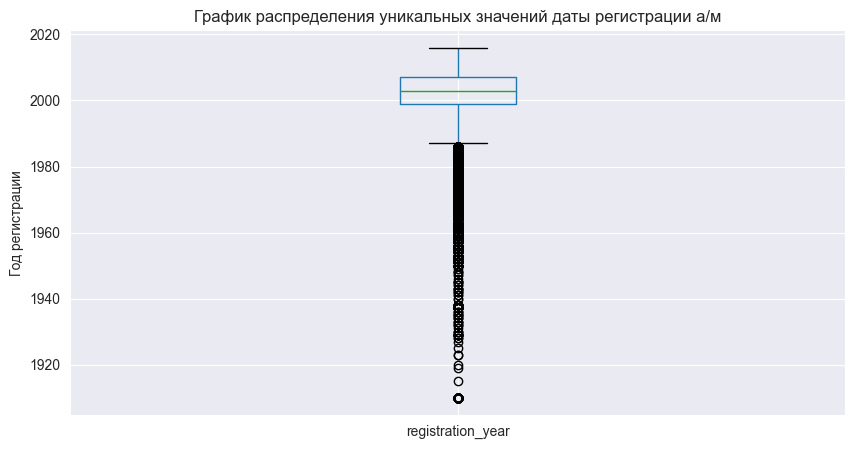

In [18]:
autos_data.boxplot('registration_year', figsize=(10, 5))
plt.title('График распределения уникальных значений даты регистрации а/м')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

Глядя на этот ящик-с-усами можно заметить, что начало основной регистрации автомобилей приходится на конец 80-х и начало 90-х, а все что было раньше 1970 - единичные случаи. Можно дополнительно ограничить год регистрации до 1970, ведь почти все автомобили старше этой даты являются коллекционными и идут в продажу совсем по другой цене, чем автомобили повседневного пользования.

In [19]:
autos_data = autos_data.query('registration_year >= 1970')

In [20]:
autos_data.shape[0]

338501

Для нижней границы мощности возьмем характеристики ГАЗ-М-21, выпуск которого закончили как раз к 1970 году. Максимальная мощность разных моделей колеблется от 60 до 85 л.с., возьмем чуть меньше - 50 л.с., это значение и будет нижним краем.

Заглянув на [сайт автоновостей](https://atlanticexpress.com.ua/samye-moshhnye-serijnye-avto-v-mire-ot-1750-l-s/) можно обратить внимание, что самым мощным автомобилем назван Lotus Evija, имеющий под капотом 2000 л.с.. Такое значение можно считать верхним краем, значения выходящие за который можно удалить.

In [21]:
autos_data = autos_data.query('power > 50 & power < 2001')

Заменим год регистрации на возраст автомобиля на момент выгрузки данных.

In [22]:
autos_data['date_crawled'] = autos_data['date_crawled'].apply(pd.to_datetime)
autos_data['age'] = pd.DatetimeIndex(autos_data['date_crawled']).year - autos_data['registration_year']
autos_data = autos_data.drop(['registration_year'], axis=1)
numeric_columns.append('age')
numeric_columns.remove('registration_year')

Посмотрим ещё раз как выглядят после обработки числовые признаки.

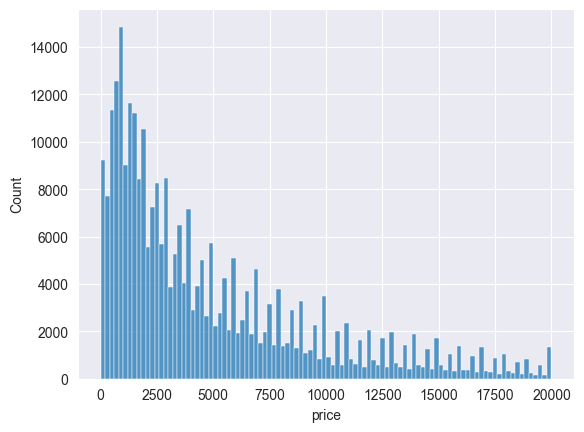

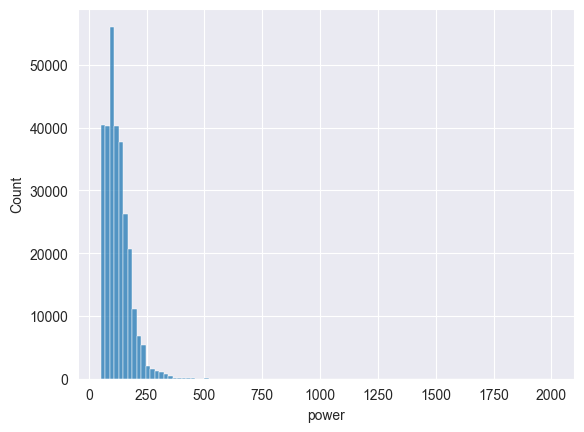

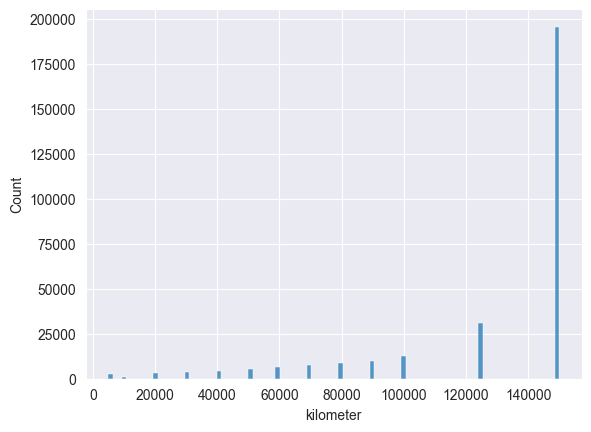

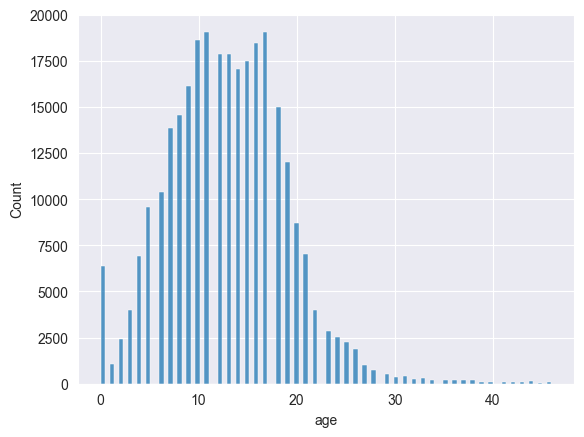

In [23]:
for column in numeric_columns:
    sns.histplot(autos_data[column], bins=100)
    plt.show()

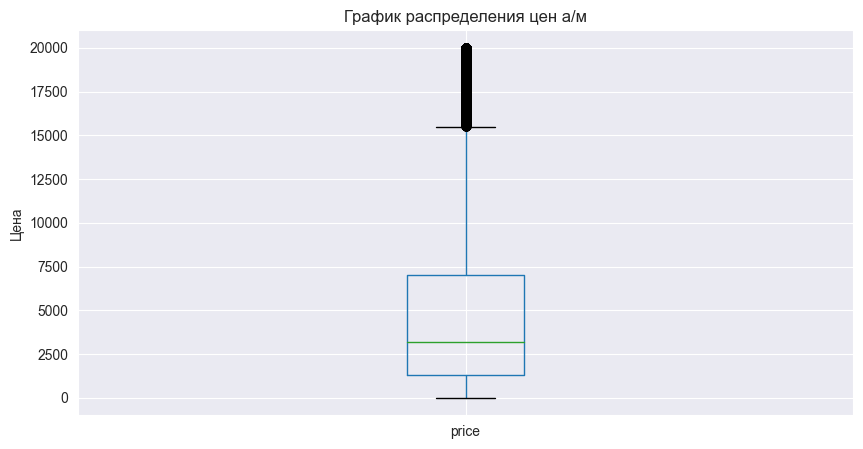

In [24]:
autos_data.boxplot('price', figsize=(10, 5))
plt.title('График распределения цен а/м')
plt.ylabel('Цена')
plt.xlabel('')
plt.show()

In [25]:
autos_data = autos_data.query('price != 0')

Для столбцов `gearbox` и `repaired` (коробка передач и был ли ремонт) можно изменить тип данных на булев:
- `gearbox_manual`: True (manual) - означает механическую коробку передач, False (auto) - автоматическую.
- `repaired`: True (yes) - означает машину с ремонтом, False (no) - без ремонта.

In [26]:
autos_data['gearbox_manual'] = autos_data['gearbox'].map({'manual': True, 'auto': False})
autos_data['repaired'] = autos_data['repaired'].map({'yes': True, 'no': False})
autos_data = autos_data.drop(['gearbox'], axis=1)

cat_columns.remove('gearbox')
cat_columns.append('gearbox_manual')

Удалим дубликаты, так как их с одной стороны немного, а с другой полное совпадение по дате обращения выглядит сомнительно.

In [27]:
autos_data = autos_data.drop_duplicates().reset_index(drop=True)

Количество стобцов: 16
Количество строк: 286549
Дубликатов: 0


,date_crawled,price,vehicle_type,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,age,gearbox_manual
279238,2016-04-02 16:53:03,550,wagon,211,omega,150000,6,petrol,opel,True,2016-04-02 00:00:00,0,42855,2016-04-06 16:15:55,20,False
181202,2016-03-19 14:57:11,2990,wagon,147,mondeo,150000,6,petrol,ford,False,2016-03-19 00:00:00,0,9114,2016-03-19 15:41:00,15,True
137598,2016-03-07 16:38:32,6300,sedan,145,focus,60000,4,petrol,ford,False,2016-03-07 00:00:00,0,70565,2016-03-10 16:49:17,10,True
188388,2016-03-17 20:54:40,1899,wagon,109,3_reihe,150000,4,petrol,peugeot,False,2016-03-17 00:00:00,0,73333,2016-04-07 11:16:12,14,True
96238,2016-04-03 01:58:08,1000,sedan,101,golf,150000,3,petrol,volkswagen,False,2016-04-03 00:00:00,0,93426,2016-04-07 08:15:50,19,True


пропусков не осталось :) 


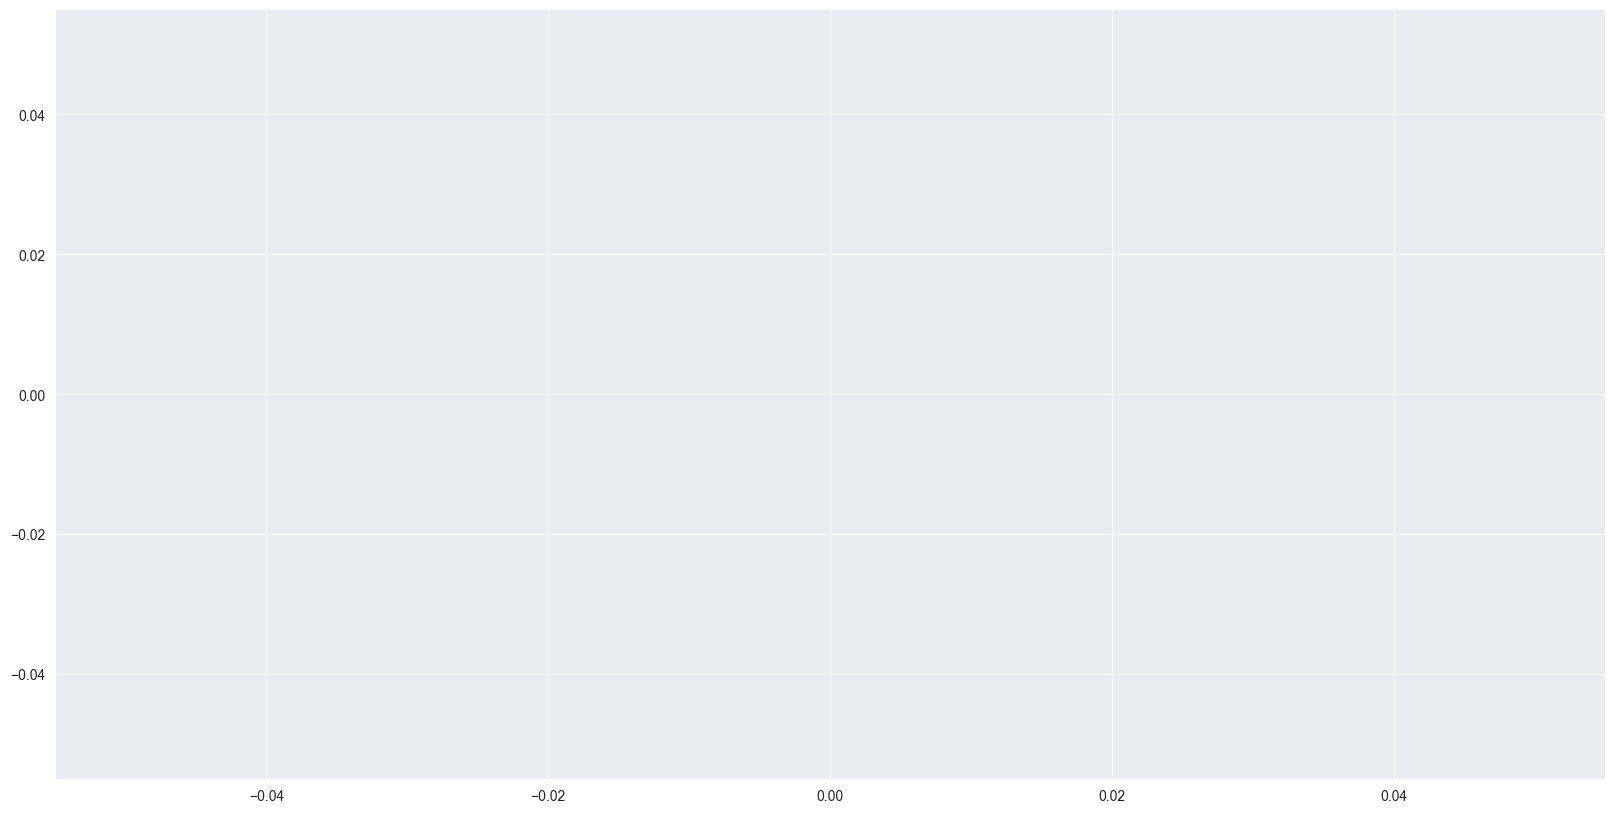

In [28]:
research_info(autos_data)
len_after = autos_data.shape[0]

In [29]:
print('После предобработки осталось {:.2%} от исходных данных'.format(len_after / len_before))

После предобработки осталось 80.86% от исходных данных


Некоторые столбцы содержат данные, которые не представляют пользы для обучения модели, а значит их можно удалить

In [30]:
autos_data = autos_data.drop(
    ['number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled'], axis=1)

In [31]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286549 entries, 0 to 286548
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   price           286549 non-null  int64 
 1   vehicle_type    286549 non-null  object
 2   power           286549 non-null  int64 
 3   model           286549 non-null  object
 4   kilometer       286549 non-null  int64 
 5   fuel_type       286549 non-null  object
 6   brand           286549 non-null  object
 7   repaired        286549 non-null  bool  
 8   age             286549 non-null  int64 
 9   gearbox_manual  286549 non-null  bool  
dtypes: bool(2), int64(4), object(4)
memory usage: 18.0+ MB


In [32]:
autos_data[cat_columns] = autos_data[cat_columns].astype('category')

Уменьшим размерность хранения типов данных для столбцов с числовыми данными для ускорения работы с датасетом.

In [33]:
for column in numeric_columns:
    autos_data[column] = pd.to_numeric(autos_data[column], downcast='integer')

In [34]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286549 entries, 0 to 286548
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   price           286549 non-null  int16   
 1   vehicle_type    286549 non-null  category
 2   power           286549 non-null  int16   
 3   model           286549 non-null  category
 4   kilometer       286549 non-null  int32   
 5   fuel_type       286549 non-null  category
 6   brand           286549 non-null  category
 7   repaired        286549 non-null  category
 8   age             286549 non-null  int8    
 9   gearbox_manual  286549 non-null  category
dtypes: category(6), int16(2), int32(1), int8(1)
memory usage: 4.4 MB


Посмотрим коррелирующие значения после предобработки данных.

In [35]:
autos_data.corr().style.background_gradient(cmap='coolwarm')

,price,power,kilometer,age
price,1.000000,0.414567,-0.394229,-0.533643
power,0.414567,1.000000,0.086280,-0.082090
kilometer,-0.394229,0.086280,1.000000,0.355864
age,-0.533643,-0.082090,0.355864,1.000000


Наблюдается умеренная положительная корреляция стоимости от мощности а/м, в то время как пробег имеет умеренную отрицательную, а возраст заметную отрицательную зависимости, что так же сказывается на ценообразовании подержанного автомобиля.

**Выводы:**
- была изучена таблица данных;
- выведены аномальные и пропущенные значения;
- отобраны необходимые столбцы для обучения модели;
- заполнены пропуски в столбцах и удалены некорректные значения;
- заменены два категориальных признака на булевы;

Далее пройдемся по признакам, значимых для нашей модели:
- `vehicle_type` - тип машины определяет ее функционал и возможности, чем их больше машины, тем выше цена;
- `age` - чем больше возраст, тем более изношен автомобиль, а значит меньше цена;
- `power` - мощность в лошадиных силах напрямую влияют на цену;
- `model` - в совокупности с типом машины и брендом может влиять на популярность у покупателей;
- `kilometer` - чем больше пробег, тем меньше ее надежность и соответственно цена. Однако, можно заметить что более 50% с пробегом 150000 при этом ни больше ни меньше, скорее всего это какое-то ограничение со стороны сайта, но разница между 150000 и 300000 довольно существенна и должна влиять на стоимость;
- `fuel_type` - тип топлива определяет конструкцию двигателя внутреннего сгорания;
- `brand` - концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля;
- `repaired` - если машина побывала в ДТП, то ее констукция уже видиизменена, следовательно надежность и качество ниже, как и цена;
- `gearbox_manual` - наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.

## Шаг 2. Работа с моделями <a class="anchor" id="section2"></a>

Перед обучением моделей данные необходимо поделить на обучающую и тестовую выборки, а так же для некоторых моделей перейти от категориальных признаков к числовым.

In [36]:
features = autos_data.drop('price', axis=1)
target = autos_data['price']

In [37]:
numeric_columns.remove('price')

In [38]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=RANDOM_VAL)
features_train_, features_val, target_train_, target_val = train_test_split(features_train,
                                                                            target_train,
                                                                            test_size=0.16,
                                                                            random_state=RANDOM_VAL)
eval_set = [(features_val, target_val)]

Создадим функции, которые позволят сравнить в конце все модели и следить за качеством по ходу работы.

In [39]:
# Генерация таблицы с метриками
def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                name: str = None,
                time_fit: str = None,
                time_pred: str = None):
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics['Time fit'] = time_fit
    df_metrics['Time pred'] = time_pred

    return df_metrics

In [40]:
# Проверка на переобучение
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric_fun(y_train, y_pred_train)
    mae_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % mae_train)
    print(f'{metric_fun.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test) / mae_train * 100):.1f} %')

Выберем следующие регрессоры для обучения модели:
- LinearRegression;
- DecisionTreeRegressor;
- <s>RandomForestRegressor;<s>
- CatBoostRegressor;
- LGBMRegressor;
- DummyRegressor.

В качестве метрики для всех моделей будем использовать MAE и в финальной таблице переведем в RMSE.

Для моделей, не поддерживающих работу с категориальными признаками составим список преобразований, включающий в себя кодирование методом OHE и масштабирование числовых данных.

In [41]:
transformers_list = [
    ('encode', OneHotEncoder(dtype='int', drop='first'),
     cat_columns),
    ('scale', StandardScaler(),
     numeric_columns)
]

column_transformer = ColumnTransformer(transformers_list)

### 2.1 LinearRegression

In [42]:
lr_pipe = Pipeline([('columnTransformer', column_transformer),
                    ('lr', LinearRegression())])

time_start_fit = time.time()
lr_pipe.fit(features_train, target_train)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred = lr_pipe.predict(features_val)
time_spent_pred = time.time() - time_start_pred

In [43]:
metrics = get_metrics(target_val, target_pred, 'LinearRegression', time_spent_fit, time_spent_pred)

In [44]:
check_overfitting(lr_pipe,
                  features_train,
                  target_train,
                  features_val,
                  target_val,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 1857.661
mean_absolute_error test: 1866.686
delta = 0.5 %


### 2.2 DecisionTreeRegressor

In [45]:
dt_pipe = Pipeline([('columnTransformer', column_transformer),
                    ('dt', DecisionTreeRegressor())])

time_start_fit = time.time()
dt_pipe.fit(features_train, target_train)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_dt = dt_pipe.predict(features_val)
time_spent_pred = time.time() - time_start_pred

In [46]:
metrics = metrics.append(
    get_metrics(target_val, target_pred_dt, 'DecisionTreeRegressor', time_spent_fit, time_spent_pred))

In [47]:
check_overfitting(dt_pipe,
                  features_train,
                  target_train,
                  features_val,
                  target_val,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 485.553
mean_absolute_error test: 484.656
delta = 0.2 %


### 2.3 RandomForestRegressor

К сожалению, модель случайного леса рассчитывается очень долго, поэтому исключим её из исследования.

In [48]:
# rf_pipe = Pipeline([('columnTransformer', column_transformer),
#                     ('rf', RandomForestRegressor())])
#
# time_start_fit = time.time()
# rf_pipe.fit(features_train, target_train)
# time_spent_fit = time.time() - time_start_fit
#
# time_start_pred = time.time()
# target_pred_rf = rf_pipe.predict(features_val)
# time_spent_pred = time.time() - time_start_pred

In [49]:
# metrics = metrics.append(
#     get_metrics(target_val, target_pred_rf, 'RandomForestRegressor', time_spent_fit, time_spent_pred))
# metrics

In [50]:
# check_overfitting(rf_pipe,
#                   features_train,
#                   target_train,
#                   features_val,
#                   target_val,
#                   metric_fun=mean_absolute_error)

### 2.4 LGBMRegressor

In [51]:
lgb = LGBMRegressor(random_state=RAND, objective='mae')

time_start_fit = time.time()
lgb.fit(features_train_,
        target_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_lgb = lgb.predict(features_val)
time_spent_pred = time.time() - time_start_pred

In [52]:
metrics = metrics.append(
    get_metrics(target_val, target_pred_lgb, 'LGBMRegressor', time_spent_fit, time_spent_pred))

In [53]:
check_overfitting(lgb,
                  features_train,
                  target_train,
                  features_val,
                  target_val,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 1017.738
mean_absolute_error test: 1040.468
delta = 2.2 %


### 2.5 CatBoostRegressor

In [54]:
cat_features = features_val.select_dtypes('category').columns.tolist()

cb = CatBoostRegressor(random_seed=RAND,
                       loss_function='MAE',
                       eval_metric='MAE',
                       cat_features=cat_features,
                       allow_writing_files=False)

time_start_fit = time.time()
cb.fit(features_train_,
       target_train_,
       eval_set=eval_set,
       verbose=0,
       early_stopping_rounds=100)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_cb = cb.predict(features_val)
time_spent_pred = time.time() - time_start_pred

In [55]:
metrics = metrics.append(
    get_metrics(target_val, target_pred_cb, 'CatBoostRegressor', time_spent_fit, time_spent_pred))

In [56]:
check_overfitting(cb,
                  features_train,
                  target_train,
                  features_val,
                  target_val,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 1049.366
mean_absolute_error test: 1065.044
delta = 1.5 %


### 2.6 DummyRegressor

In [57]:
dr_pipe = Pipeline([('columnTransformer', column_transformer),
                    ('dr', DummyRegressor())])

time_start_fit = time.time()
dr_pipe.fit(features_train, target_train)
time_spent_fit = time.time() - time_start_fit

time_start_pred = time.time()
target_pred_dr = dr_pipe.predict(features_val)
time_spent_pred = time.time() - time_start_pred

In [58]:
metrics = metrics.append(
    get_metrics(target_val, target_pred_dr, 'DummyRegressor', time_spent_fit, time_spent_pred))

In [59]:
check_overfitting(dr_pipe,
                  features_train,
                  target_train,
                  features_val,
                  target_val,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 3658.373
mean_absolute_error test: 3670.298
delta = 0.3 %


**Выводы:**
- модели обучены;
- предсказания составлены;
- параметры качества моделей занесены в таблицу.

Можно обратить внимание, что в DecisionTreeRegressor очень большой показатель переобучения.

## Шаг 3. Оценка качества моделей <a class="anchor" id="section3"></a>

Выведем таблицу с метриками и выберем лучшую модель по совокупности параметров.

In [60]:
metrics

,model,MAE,MSE,RMSE,Time fit,Time pred
0,LinearRegression,1866.686473,7.483101e+06,2735.525731,2.835552,0.042522
0,DecisionTreeRegressor,484.655889,8.193539e+05,905.181721,22.700106,0.057818
0,LGBMRegressor,1040.467578,2.904729e+06,1704.326593,0.638419,0.043368
0,CatBoostRegressor,1065.043787,3.045710e+06,1745.196214,63.967248,0.025402
0,DummyRegressor,3670.297972,2.146918e+07,4633.484847,0.295814,0.040450


- `LGBMRegressor` (1050 евро, конечно неприятная погрешность, в некоторых случаях можно купить ещё один автомобиль), обучение заняло больше всего времени.
- `CatBoostRegressor` обучается достаточно долго по сравнению с более простыми моделями, но имеет самую высокую скорость предсказания, достаточно высокую точность предсказания (28 евро разницы с LGBMRegressor).
- `DecisionTreeRegressor` показала себя как достаточно быструю и в обучении и в предсказании модель, а также имеющую довольно высокое качество предсказания, однако переобученность модели вызывает сомнения.
- `LinearRegression` оказалась в текущем случае самой быстрой (не считая дамми-модели) в обучении, но второй по скорости предсказания и не подходящей по качеству предсказания.
- `DummyRegressor` очень быстрая, но очень неточная модель, которая позволила нам убедиться в адекватности предсказаний других моделей.

In [61]:
time_spent_fit = '-'
time_start_pred = time.time()
target_pred_lgb = lgb.predict(features_test)
time_spent_pred = time.time() - time_start_pred
get_metrics(target_test, target_pred_lgb, 'LGBMRegressor', time_spent_fit, time_spent_pred)

,model,MAE,MSE,RMSE,Time fit,Time pred
0,LGBMRegressor,1038.059186,2.838253e+06,1684.711695,-,0.070736


**Выводы:**
Исходя из совокупности требований заказчика, я бы рекомендовала бы взять в работу `LGBMRegressor`, который 'из коробки' выдает достаточно хорошие показатели в качестве и скорости предсказания.

## Шаг 4. Общий вывод <a class="anchor" id="section4"></a>
В ходе проделанной работы было выполнено:
1. В рамках подготовки данных:
- проведена предобработка данных;
- проанализированы признаки важные и неважные для моделей.
2. В рамках работы с моделями:
- исследованы модели регрессии;
- получена таблица сравнительных признаков качества моделей.
3. В рамках анализа различных моделей:
- выбрана лучшая модель;
- её качество проверено на тестовой выборке;
- модель прошла проверку DummyRegressor;
- составлен вывод и рекомендации заказчику.
